In [11]:
%matplotlib inline

import torch
import glob
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# install cleverhans from source to get pytorch support
import cleverhans
from cleverhans.future.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [2]:
# load the MobileNet model used in Percival
model = torch.load("darknight.pth")
model.eval()

/home/tramer/tramer/ads/percival/env/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'ModuleSqueezeNet1.SqueezeNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/tramer/tramer/ads/percival/env/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/tramer/tramer/ads/percival/env/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve t

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=

In [25]:
# load an image from disk and preprocess it as in Percival
def load_and_preproc(f, h=224, w=224):
    img = Image.open(f)
    img = img.convert('RGB')
    
    width, height = img.size   # Get dimensions
    
    if width < 100 or height < 100:
        return None
    
    if width == 225 and height == 225:
        left = 0
        top = 0
        right = w
        bottom = h
        img = img.crop((left, top, right, bottom))
    else:
        img = img.resize((h, w), PIL.Image.ANTIALIAS)
    img = np.asarray(img).astype(np.float32)
    img = (img / 127.5) - 1.0
    
    return img

In [26]:
# load an ad
X_ad = np.asarray([load_and_preproc('../../data/web/www.cnn.com/ads/frame_5.png')])
Y_ad = [0]

# create an opaque box
X_no_ad = 0.5 + np.zeros_like(X_ad)
Y_no_ad = [1]

In [27]:
device = "cuda" # [cuda | cpu]
model = model.to(device)
outputs_ad = model(torch.from_numpy(np.transpose(X_ad, (0, 3, 1, 2))).to(device))
outputs_no_ad = model(torch.from_numpy(np.transpose(X_no_ad, (0, 3, 1, 2))).to(device))

In [28]:
# predictions: 0="ad", 1="not ad"
print(outputs_ad.detach().cpu().numpy().argmax(axis=-1))
print(outputs_no_ad.detach().cpu().numpy().argmax(axis=-1))

[0]
[1]


In [29]:
# create adversarial examples

X = np.concatenate([np.transpose(X_ad, (0, 3, 1, 2)), np.transpose(X_no_ad, (0, 3, 1, 2))])
Y = np.concatenate([np.zeros(len(X_ad)), np.ones(len(X_no_ad))]).astype(np.long)

batch_size = min(10, len(X))
num_batches = len(X) // batch_size
eps = 8/255.0
iters = 10
eps_iter = 2.5 * eps / iters
model_fn = lambda x: model(x)

all_outputs = []
all_adv_X = []

for i in range(num_batches):

    x = torch.from_numpy(X[i*batch_size:(i+1)*batch_size]).to(device)
    y = torch.from_numpy(Y[i*batch_size:(i+1)*batch_size]).to(device)
    adv_x = x
    
    outputs_adv = model(adv_x)
    
    # apply PGD a few times and reconvert to a valid uint8 RGB image between each attack
    k = 4
    for _ in range(k):
        adv_x = projected_gradient_descent(model_fn, adv_x, eps/k, eps_iter/k, iters, np.inf,
                                           clip_min=-1.0, clip_max=1.0, y=y, targeted=False,
                                           rand_init=None, sanity_checks=False)
        adv_x = adv_x.detach().cpu().numpy()
        adv_x = (((adv_x + 1) / 2.0) * 255.0).astype(np.uint8)
        adv_x = (adv_x.astype(np.float32) / 127.5) - 1.0
        adv_x = torch.from_numpy(adv_x).to(device)
    
    outputs_adv = model(adv_x)        
    outputs_adv = outputs_adv.detach().cpu().numpy().argmax(axis=-1)
    all_outputs.extend(outputs_adv)
    all_adv_X.append(adv_x.detach().cpu().numpy())
print(all_outputs)
print(Y)

[1, 0]
[0 1]


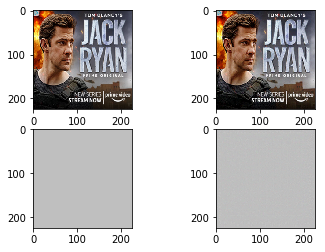

In [30]:
img = (X_ad[0] + 1) / 2.0
img_adv = (all_adv_X[0][0].transpose((1, 2, 0)) + 1) / 2.0

fp = (X_no_ad[0] + 1) / 2.0
fp_adv = (all_adv_X[0][1].transpose((1, 2, 0)) + 1) / 2.0

img = np.pad((img * 255.0).astype(np.uint8), ((0,1), (0,1), (0,0)), 'constant')
img_adv = np.pad((img_adv * 255.0).astype(np.uint8), ((0,1), (0,1), (0,0)), 'constant')
fp = np.pad((fp * 255.0).astype(np.uint8), ((0,1), (0,1), (0,0)), 'constant')
fp_adv = np.pad((fp_adv * 255.0).astype(np.uint8), ((0,1), (0,1), (0,0)), 'constant')

_, ax = plt.subplots(2,2)
ax[0,0].imshow(img)
ax[0,1].imshow(img_adv)
ax[1,0].imshow(fp)
ax[1,1].imshow(fp_adv)
plt.show()

im = Image.fromarray(img_adv)
im.save("ad_adv.png")
im = Image.fromarray(img)
im.save("ad.png")
im = Image.fromarray(fp)
im.save("fp.png")
im = Image.fromarray(fp_adv)
im.save("fp_adv.png")

In [31]:
# load the adversarial images and re-classify to make sure the attack worked

imgs = np.asarray([load_and_preproc(img) for img in ["ad.png", "ad_adv.png", "fp.png", "fp_adv.png"]])
outputs = model(torch.from_numpy(np.transpose(imgs, (0, 3, 1, 2))).to(device))
assert((outputs.detach().cpu().numpy().argmax(axis=-1) == np.array([0, 1, 1, 0])).all())

In [46]:
# load all the frames in our dataset

test_images_path = "../../data/web/all_frames.txt"
all_ads_path = "../../data/web/all_ads.txt"

with open(test_images_path, 'r') as f:
    test_images = [line.rstrip() for line in f.readlines()]

with open(all_ads_path, 'r') as f:
    all_ads = [line.rstrip() for line in f.readlines()]

is_ad = [f in all_ads for f in test_images]
X = np.asarray([load_and_preproc('../../' + f) for f in test_images])
Y = np.ones(len(X))
Y[is_ad] = 0

too_small = np.asarray([x is None for x in X])
X = X[~too_small]
Y = Y[~too_small]

X = np.stack(X, axis=0)

(40, 224, 224, 3)


In [50]:
# classify all the frames
outputs = model(torch.from_numpy(np.transpose(X, (0, 3, 1, 2))).to(device))
preds = outputs.detach().cpu().numpy().argmax(axis=-1)

print("FP: {}/{}".format(np.sum((Y == 1) & (preds == 0)), np.sum(Y == 1)))
print("FN: {}/{}".format(np.sum((Y == 0) & (preds == 1)), np.sum(Y == 0)))

FP: 2/7
FN: 0/33


In [58]:
# attack all the frames

x = torch.from_numpy(np.transpose(X, (0, 3, 1, 2))).to(device)
y = torch.from_numpy(Y.astype(np.long)).to(device)

adv_x = projected_gradient_descent(model_fn, x, eps, eps_iter, iters, np.inf,
                                   clip_min=-1.0, clip_max=1.0, y=y, targeted=False,
                                   rand_init=None, sanity_checks=False)
    
outputs_adv = model(adv_x)        
preds_adv = outputs_adv.detach().cpu().numpy().argmax(axis=-1)

print("FP (adv): {}/{}".format(np.sum((Y == 1) & (preds_adv == 0)), np.sum(Y == 1)))
print("FN (adv): {}/{}".format(np.sum((Y == 0) & (preds_adv == 1)), np.sum(Y == 0)))

FP (adv): 7/7
FN (adv): 33/33


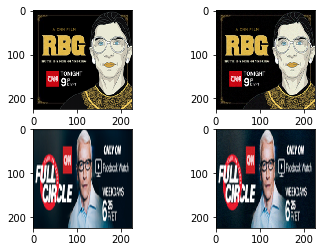

In [59]:
# show some examples

X_adv = adv_x.detach().cpu().numpy()

img = (X[0] + 1) / 2.0
img_adv = (X_adv[0].transpose((1, 2, 0)) + 1) / 2.0

fp = (X[1] + 1) / 2.0
fp_adv = (X_adv[1].transpose((1, 2, 0)) + 1) / 2.0

img = np.pad((img * 255.0).astype(np.uint8), ((0,1), (0,1), (0,0)), 'constant')
img_adv = np.pad((img_adv * 255.0).astype(np.uint8), ((0,1), (0,1), (0,0)), 'constant')
fp = np.pad((fp * 255.0).astype(np.uint8), ((0,1), (0,1), (0,0)), 'constant')
fp_adv = np.pad((fp_adv * 255.0).astype(np.uint8), ((0,1), (0,1), (0,0)), 'constant')

_, ax = plt.subplots(2,2)
ax[0,0].imshow(img)
ax[0,1].imshow(img_adv)
ax[1,0].imshow(fp)
ax[1,1].imshow(fp_adv)
plt.show()